# **Airline Passenger Satisfaction - Modeling & Evaluation**

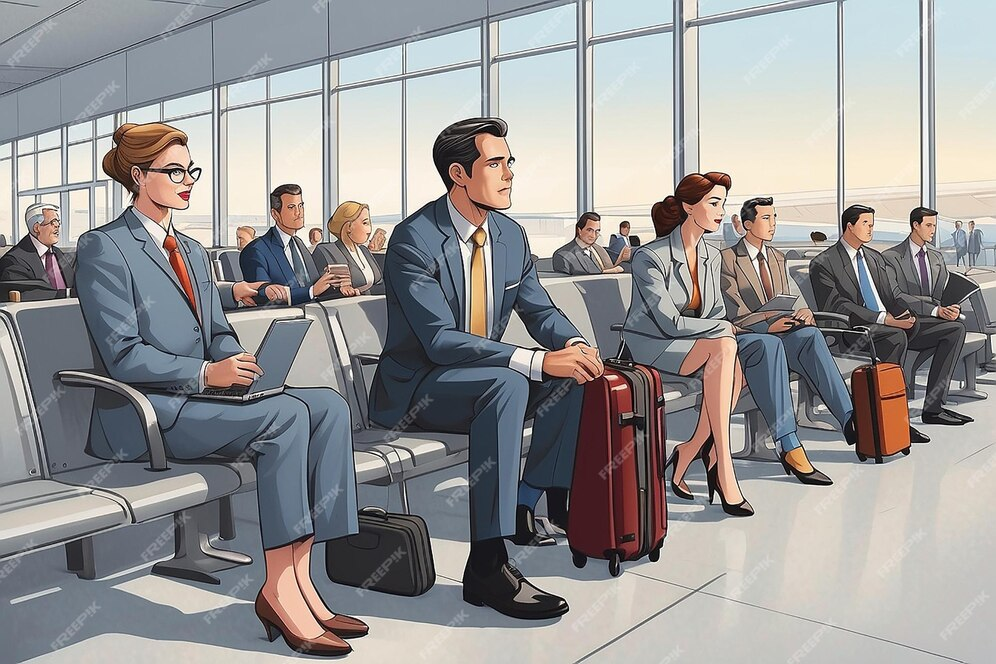

This project is divided into two notebooks for clarity and better organization:

* The **first notebook** focuses on **Exploratory Data Analysis (EDA) and Data Preprocessing**. It includes tasks such as analyzing the dataset, visualizing key patterns, handling missing data, addressing outliers, feature engineering, and preparing the data for model development. By the end of this notebook, the preprocessed data is saved and ready to be used in modeling tasks.

* The **second notebook** covers **Model Development and Evaluation**. This includes building and tuning machine learning models, performing feature selection using SHAP values, and comparing different models. The goal is to select the best model and evaluate its performance on the test set, with the final step being saving the trained model for future use.

These two notebooks work together, ensuring a clear separation between data exploration and model training, making the workflow more structured and easier to follow.

---

The dataset is available [here](https://www.kaggle.com/datasets/teejmahal20/airline-passenger-satisfaction), and the variable descriptions are listed below.
- **Gender**: Gender of the passengers (Female, Male)
- **Customer Type**: The customer type (Loyal customer, disloyal customer)
- **Age**: The actual age of the passengers
- **Type of Travel**: Purpose of the flight of the passengers (Personal Travel, Business Travel)
- **Class**: Travel class in the plane of the passengers (Business, Eco, Eco Plus)
- **Flight distance**: The flight distance of this journey
- **Inflight wifi service**: Satisfaction level of the inflight wifi service (0:Not Applicable;1-5)
- **Departure/Arrival time convenient**: Satisfaction level of Departure/Arrival time convenient
- **Ease of Online booking**: Satisfaction level of online booking
- **Gate location**: Satisfaction level of Gate location
- **Food and drink**: Satisfaction level of Food and drink
- **Online boarding**: Satisfaction level of online boarding
- **Seat comfort**: Satisfaction level of Seat comfort
- **Inflight entertainment**: Satisfaction level of inflight entertainment
- **On-board service**: Satisfaction level of On-board service
- **Leg room service**: Satisfaction level of Leg room service
- **Baggage handling**: Satisfaction level of baggage handling
- **Check-in service**: Satisfaction level of Check-in service
- **Inflight service**: Satisfaction level of inflight service
- **Cleanliness**: Satisfaction level of Cleanliness
- **Departure Delay in Minutes**: Minutes delayed when departure
- **Arrival Delay in Minutes**: Minutes delayed when Arrival
- **Satisfaction**: Airline satisfaction level(Satisfaction, neutral or dissatisfaction)

## Table of Content

1. [Import Libraries and Load Preprocessed Dataset](#section-one)
2. [Model Development](#section-two)
  * [Baseline Model Evaluation](#section-two-one)
  * [Hyperparameter Tuning with Optuna](#section-two-two)
      - [LightGBM Optimization](#section-two-two-one)
      - [CatBoost Optimization](#section-two-two-two)
      - [XGBoost Optimization](#section-two-two-three)
  * [Feature Selection Using SHAP Values](#section-two-three)
3. [Final Model Evaluation](#section-three)
      - [Comparison of Full Feature Model vs. SHAP Selected Feature Model](#section-three-one)
      - [Predictions on the Test Set and Final Evaluation Metrics](#section-three-two)
      - [Save the Final Model](#section-three-three)


<a name="section-one"></a>
# **1. Import Libraries and Load Preprocessed Dataset**

In this section, I will import the necessary libraries required for model development, hyperparameter tuning, feature selection, and evaluation. I will also load the preprocessed dataset that was saved from the first notebook. This will be used to build and evaluate machine learning models, ensuring consistency betIen data preprocessing and modeling phases.

In [ ]:
%%capture
!pip install catboost
!pip install optuna
!pip install optuna-integration
!pip install shap

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_validate, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import xgboost as xgb
from lightgbm import LGBMClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import (
    make_scorer, accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report, roc_curve)

import optuna
from optuna.integration import LightGBMPruningCallback, CatBoostPruningCallback
import shap
import time
import joblib

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
df_train_preprocessed = pd.read_csv('/content/train_preprocessed.csv')
df_test_preprocessed = pd.read_csv('/content/test_preprocessed.csv')

<a name="section-two"></a>
# **2. Model Development**

This section covers the core model building and evaluation process. It begins with evaluating baseline models, followed by hyperparameter tuning using Optuna to optimize model performance. We will also conduct feature selection using SHAP values to understand feature importance.

* **Baseline Model Evaluation:**
  - Before tuning, we evaluate several baseline models using default parameters. This provides a benchmark for assessing how much improvement can be achieved through hyperparameter tuning and feature selection.

* **Hyperparameter Tuning with Optuna:**
  - Using the Optuna framework, we perform hyperparameter tuning for several models to optimize their performance on the dataset. Optuna’s automatic optimization allows us to explore a wide range of hyperparameters efficiently.
    - **LightGBM Optimization:**
    - **CatBoost Optimization:**
    - **XGBoost Optimization:**
* **Feature Selection Using SHAP Values:**
  - SHAP values allow us to assess the contribution of each feature to the model's predictions. In this step, we will identify the most important features and create a new model using only the selected features to compare its performance with the full feature model

In [ ]:
X = df_train_preprocessed.drop(columns="satisfaction")
y = df_train_preprocessed.satisfaction

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

<a name="section-two-one"></a>
## **a. Baseline Model Evaluation**


- **Logistic Regression:** Baseline, simple and interpretable.
- **KNN:** Non-parametric, often useful for small datasets but can be computationally expensive.
- **Decision Tree:** Easy to interpret but can overfit.
- **RandomForest:** Strong baseline ensemble model with built-in feature importance.
- **Gradient Boosting/XGBoost/LightGBM:** Strong performance in many tasks.
- **SVC**: Good for non-linear relationships.
- **Naive Bayes:** Good for small datasets, probabilistic modeling.
- **Balanced RandomForest:** For imbalanced datasets.


In [ ]:
def base_models(X, y, cv=5):
    print("Evaluating Base Models...\n")

    classifiers = [
        ('LR', LogisticRegression(max_iter=1000)),
        ('KNN', KNeighborsClassifier()),
        ('CART', DecisionTreeClassifier()),
        ('RF', RandomForestClassifier()),
        ('GBM', GradientBoostingClassifier()),
        ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
        ('LightGBM', LGBMClassifier()),
        ('CatBoost', CatBoostClassifier(verbose=False)),
        # ('SVC', SVC(probability=True)),
        ('NaiveBayes', GaussianNB()),
        ('BalancedRF', BalancedRandomForestClassifier())
    ]

    scoring = {
        'accuracy': make_scorer(accuracy_score),
        'f1': make_scorer(f1_score, average='weighted'),
        'precision': make_scorer(precision_score, average='weighted'),
        'recall': make_scorer(recall_score, average='weighted'),
        'roc_auc': 'roc_auc'
    }

    results = []

    for name, classifier in classifiers:
        print("\n" + "*" * 50)
        print(f"**** RUNNING ALGORITHM: {name} ****".center(50, '*'))
        print("*" * 50)

        cv_results = cross_validate(classifier, X, y, cv=cv, scoring=scoring, return_train_score=False, n_jobs=-1)
        model_results = {
            'Model': name,
            'Fit Time': round(cv_results['fit_time'].mean(), 2),
            'ROC AUC': round(cv_results['test_roc_auc'].mean(), 4),
            'Recall': round(cv_results['test_recall'].mean(), 4),
            'Precision': round(cv_results['test_precision'].mean(), 4),
            'F1 Score': round(cv_results['test_f1'].mean(), 4),
            'Accuracy': round(cv_results['test_accuracy'].mean(), 4)
        }
        results.append(model_results)

        print(f"Fit Time:  {model_results['Fit Time']}s")
        print(f"ROC AUC:   {model_results['ROC AUC']}")
        print(f"Recall:    {model_results['Recall']}")
        print(f"Precision: {model_results['Precision']}")
        print(f"F1 Score:  {model_results['F1 Score']}")
        print(f"Accuracy:  {model_results['Accuracy']}")

    print("\nFinished evaluating all base models.")

    results_df = pd.DataFrame(results)
    return results_df


base_results = base_models(X_train, y_train)

Evaluating Base Models...


**************************************************
************* RUNNING ALGORITHM: LR **************
**************************************************
Fit Time:  1.65s
ROC AUC:   0.926
Recall:    0.8745
Precision: 0.8744
F1 Score:  0.8741
Accuracy:  0.8745

**************************************************
************* RUNNING ALGORITHM: KNN *************
**************************************************
Fit Time:  0.06s
ROC AUC:   0.9647
Recall:    0.919
Precision: 0.9195
F1 Score:  0.9186
Accuracy:  0.919

**************************************************
************ RUNNING ALGORITHM: CART *************
**************************************************
Fit Time:  0.7s
ROC AUC:   0.9427
Recall:    0.9435
Precision: 0.9435
F1 Score:  0.9435
Accuracy:  0.9435

**************************************************
************* RUNNING ALGORITHM: RF **************
**************************************************
Fit Time:  18.46s
ROC AUC:   0.9934
Reca

In [ ]:
def highlight_max(s):
    max_value = s.max()
    return ['background-color: lightgreen' if v == max_value else '' for v in s]

def highlight_min(s):
    min_value = s.min()
    return ['background-color: red' if v == min_value else '' for v in s]

styled_results_df = (
    base_results.style
    .apply(highlight_max, subset=['Accuracy', 'F1 Score', 'Precision', 'Recall', 'ROC AUC'])
    # .apply(highlight_min, subset=['MAE', 'MSE', 'RMSE'])  # Modify this if applicable
)

styled_results_df

,Model,Fit Time,ROC AUC,Recall,Precision,F1 Score,Accuracy
0,LR,1.650000,0.926000,0.874500,0.874400,0.874100,0.874500
1,KNN,0.060000,0.964700,0.919000,0.919500,0.918600,0.919000
2,CART,0.700000,0.942700,0.943500,0.943500,0.943500,0.943500
3,RF,18.460000,0.993400,0.961300,0.961500,0.961200,0.961300
4,GBM,21.720000,0.987200,0.941000,0.941000,0.940900,0.941000
5,XGBoost,1.560000,0.994800,0.963100,0.963200,0.963000,0.963100
6,LightGBM,2.760000,0.994700,0.963800,0.964100,0.963700,0.963800
7,CatBoost,51.690000,0.995100,0.964400,0.964600,0.964300,0.964400
8,NaiveBayes,0.070000,0.917200,0.860100,0.860100,0.859500,0.860100
9,BalancedRF,16.300000,0.993200,0.959600,0.959600,0.959500,0.959600


After examining the base model metrics, **CatBoost**, **LightGBM**, and **XGBoost** have the highest scores. Therefore, I will use Optuna to search for their best hyperparameters within the search space.

<a name="section-two-two"></a>
## **b. Hyperparameter Tuning with Optuna**

In [ ]:
def show_optuna_results(study):
    complete_trials = study.get_trials(deepcopy=False, states=[optuna.trial.TrialState.COMPLETE])
    pruned_trials = study.get_trials(deepcopy=False, states=[optuna.trial.TrialState.PRUNED])

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("\nBest trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

<a name="section-two-two-one"></a>
### **b1. LightGBM Optimization**

In [ ]:
def objective_lgbm(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 3.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 3.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 100)
    }


    model = LGBMClassifier(**params, early_stopping_rounds=100, verbose=-1)
    model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='auc',
        callbacks=[LightGBMPruningCallback(trial, "auc")]

    )

    preds_valid = model.predict(X_test)
    accuracy = accuracy_score(y_test, preds_valid)
    return accuracy

optuna.logging.set_verbosity(optuna.logging.WARNING)
study_lgbm = optuna.create_study(pruner=optuna.pruners.MedianPruner(n_warmup_steps=10),
                                 direction='maximize', study_name='LGBM Classifier')
study_lgbm.optimize(objective_lgbm, n_trials=200, show_progress_bar=True)
best_params_lgbm = study_lgbm.best_params

  0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
show_optuna_results(study_lgbm)

Study statistics: 
  Number of finished trials:  200
  Number of pruned trials:  101
  Number of complete trials:  99

Best trial:
  Value:  0.9657379336894278
  Params: 
    learning_rate: 0.16633802043012058
    n_estimators: 484
    max_depth: 15
    subsample: 0.8724194677673968
    colsample_bytree: 0.7262734004732027
    reg_lambda: 0.00034078368676886253
    reg_alpha: 0.1256469747070405
    num_leaves: 121
    min_child_samples: 57


<a name="section-two-two-two"></a>
### **b2. Catboost Optimization**

In [ ]:
def objective_catboost(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000, step=100),  # Default is 1000
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),  # Default is 0.03
        'depth': trial.suggest_int('depth', 4, 10),  # Default is 6
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 10.0, log=True),  # Default 3
        'border_count': trial.suggest_int('border_count', 32, 255),  # Default 254
        'bootstrap_type': trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli', 'MVS']),
        'eval_metric': 'Accuracy',
        'loss_function': 'Logloss',  # Use Logloss for classification
        # 'task_type': 'GPU',  # Enable GPU if available
        'verbose': False  # Silence verbose logs
    }

    if params['bootstrap_type'] != 'Bayesian':
        params['subsample'] = trial.suggest_float('subsample', 0.1, 1.0)
    if params['bootstrap_type'] == 'Bayesian':
        params['bagging_temperature'] = trial.suggest_float('bagging_temperature', 0, 10)

    model = CatBoostClassifier(**params)
    pruning_callback = CatBoostPruningCallback(trial, "Accuracy")
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=100, verbose=False,
                      callbacks=[pruning_callback])

    pruning_callback.check_pruned()

    preds_valid = model.predict(X_test)
    accuracy = accuracy_score(y_test, preds_valid)
    return accuracy


optuna.logging.set_verbosity(optuna.logging.WARNING)
study_catboost = optuna.create_study(pruner=optuna.pruners.MedianPruner(n_warmup_steps=5),
                                     direction='maximize', study_name='Catboost Classifier')
study_catboost.optimize(objective_catboost, n_trials=200, show_progress_bar=True)
best_params_catboost = study_catboost.best_params

  0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
show_optuna_results(study_catboost)

Study statistics: 
  Number of finished trials:  200
  Number of pruned trials:  154
  Number of complete trials:  46

Best trial:
  Value:  0.9643905490592368
  Params: 
    iterations: 600
    learning_rate: 0.2989272792008484
    depth: 10
    l2_leaf_reg: 2.7933251895087583
    border_count: 215
    bootstrap_type: MVS
    subsample: 0.5967356825039594


<a name="section-two-two-three"></a>
### **b3. XGB Optimization**

In [ ]:
def objective_xgb(trial):
    params = {
        **{
          'booster': trial.suggest_categorical('booster', ['gbtree', 'dart']),  # Default booster: 'gbtree'
          'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),  # Default: 0.3
          'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=100),  # Default: 100
          'subsample': trial.suggest_float('subsample', 0.5, 1.0),  # Default: 1
          'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),  # Default: 1
          'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 3.0, log=True),  # Default: 1
          'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 3.0, log=True),  # Default: 0
          'gamma': trial.suggest_float('gamma', 0, 0.5),  # Default: 0
          'use_label_encoder': False,  # Disable warning for label encoding
          "eval_metric": "auc"
        }
    }

    if params['booster'] in ['gbtree', 'dart']:
        params['max_depth'] = trial.suggest_int('max_depth', 3, 15, step=2)  # Default: 6
        params['min_child_weight'] = trial.suggest_int('min_child_weight', 2, 10)  # Default: 1
        params['grow_policy'] = trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide'])  # Default: 'depthwise'

    if params['booster'] == 'dart':
        params['sample_type'] = trial.suggest_categorical('sample_type', ['uniform', 'weighted'])
        params['normalize_type'] = trial.suggest_categorical('normalize_type', ['tree', 'forest'])
        params['rate_drop'] = trial.suggest_float('rate_drop', 1e-8, 1.0, log=True)  # Default: 0
        params['skip_drop'] = trial.suggest_float('skip_drop', 1e-8, 1.0, log=True)  # Default: 0

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "test-auc")
    bst = xgb.train(params, dtrain, evals=[(dtest, "test")], callbacks=[pruning_callback], verbose_eval=False)
    preds_valid = bst.predict(dtest)
    preds_valid = (preds_valid >= 0.5).astype(int)

    accuracy = accuracy_score(y_test, preds_valid)
    return accuracy


optuna.logging.set_verbosity(optuna.logging.WARNING)
study_xgb = optuna.create_study(pruner=optuna.pruners.MedianPruner(n_warmup_steps=5), direction="maximize")
study_xgb.optimize(objective_xgb, n_trials=200, show_progress_bar=True)
best_params_xgb = study_xgb.best_params

  0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
show_optuna_results(study_xgb)

Study statistics: 
  Number of finished trials:  200
  Number of pruned trials:  104
  Number of complete trials:  96

Best trial:
  Value:  0.9628988017900967
  Params: 
    booster: gbtree
    learning_rate: 0.1516468948045736
    n_estimators: 1000
    subsample: 0.9533647446262226
    colsample_bytree: 0.8928217961660498
    reg_lambda: 0.0007516860058541539
    reg_alpha: 0.00019797864078587965
    gamma: 0.07913035391349313
    max_depth: 13
    min_child_weight: 8
    grow_policy: depthwise


### **Insights of Hyperparameter Tuning**
* Compare Pre- and Post-Optimization Results:

<center>

| Model	   | Baseline Accuracy | Optimized Accuracy |
| :------: | :---------------: | :----------------: |
| LightGBM | 0.9638            | 0.9657             |
| CatBoost | 0.9644            | 0.9644             |
| XGBoost  | 0.9631            | 0.9629             |

</center>

* Among the top three algorithms that produced the best metric results, LightGBM achieved the highest accuracy after hyperparameter tuning with Optuna. Hence, I will continue with LightGBM and its optimal parameters.
----

### **Expanded Hyperparameter Insights for LightGBM**
**Hyperparameter Optimization Summary for LightGBM**
1. **Learning Rate (0.1633) (default: 0.1):**
  - A higher learning rate enables faster convergence towards the optimal solution, allowing the model to learn more effectively from the training data.

2. **Number of Estimators (484) (default: 100):**
  - Increasing the number of estimators enhances model performance by allowing for more complex decision boundaries, though it raises the risk of overfitting.

3. **Max Depth (15) (default: -1):**
 - A deeper tree can model complex patterns in the data, beneficial for accuracy but requires careful tuning to avoid overfitting.

4. **Subsample (0.8724) (default: 1.0):**
  - Controls the fraction of samples used for fitting trees. A value below 1.0 introduces randomness, helping to generalize the model and reduce overfitting.

5. **Colsample Bytree (0.7263) (default: 1.0):**
  - Specifies the fraction of features to sample for each tree. A value closer to 1.0 captures more information while balancing the risk of overfitting.

6. **Regularization Parameters:**
  - **Reg_lambda (3.41e-04) (default: 0.0) and Reg_alpha (1.26e-01) (default: 0.0):**
    * Very small values suggest minimal regularization was necessary, allowing the model to leverage complex relationships without heavy penalization.

7. **Number of Leaves (121) (default: 31):**
 - Directly influences model complexity. More leaves enable capturing intricate patterns, positively contributing to accuracy.

8. **Min Child Samples (57) (default: 20):**
  - Defines the minimum number of samples in a leaf node. This value ensures leaf nodes are populated enough to prevent overly specific splits that could lead to overfitting.


**Brief Hyperparameter Insights for Other Models**
* **XGBoost**
  - The tuning of key parameters like learning rate and max depth generally follows similar principles as LightGBM, focusing on achieving the best balance between model complexity and overfitting.
* **CatBoost**
  - Important parameters such as iterations and learning rate are typically fine-tuned, prioritizing the model's ability to capture interactions between features while ensuring generalization.
* **Conclusion**
  - By focusing on LightGBM and providing brief notes for the other two models, you maintain clarity while highlighting the critical aspects of your optimization process. This approach keeps your analysis succinct and allows readers to understand the most significant changes in hyperparameters without overwhelming them with details.

<a name="section-two-three"></a>
## **c. Feature Selection Using SHAP Values**

In [ ]:
final_model = LGBMClassifier(**best_params_lgbm, verbose=-1)
final_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='auc')

explainer = shap.TreeExplainer(final_model)
shap_values = explainer(X_train)

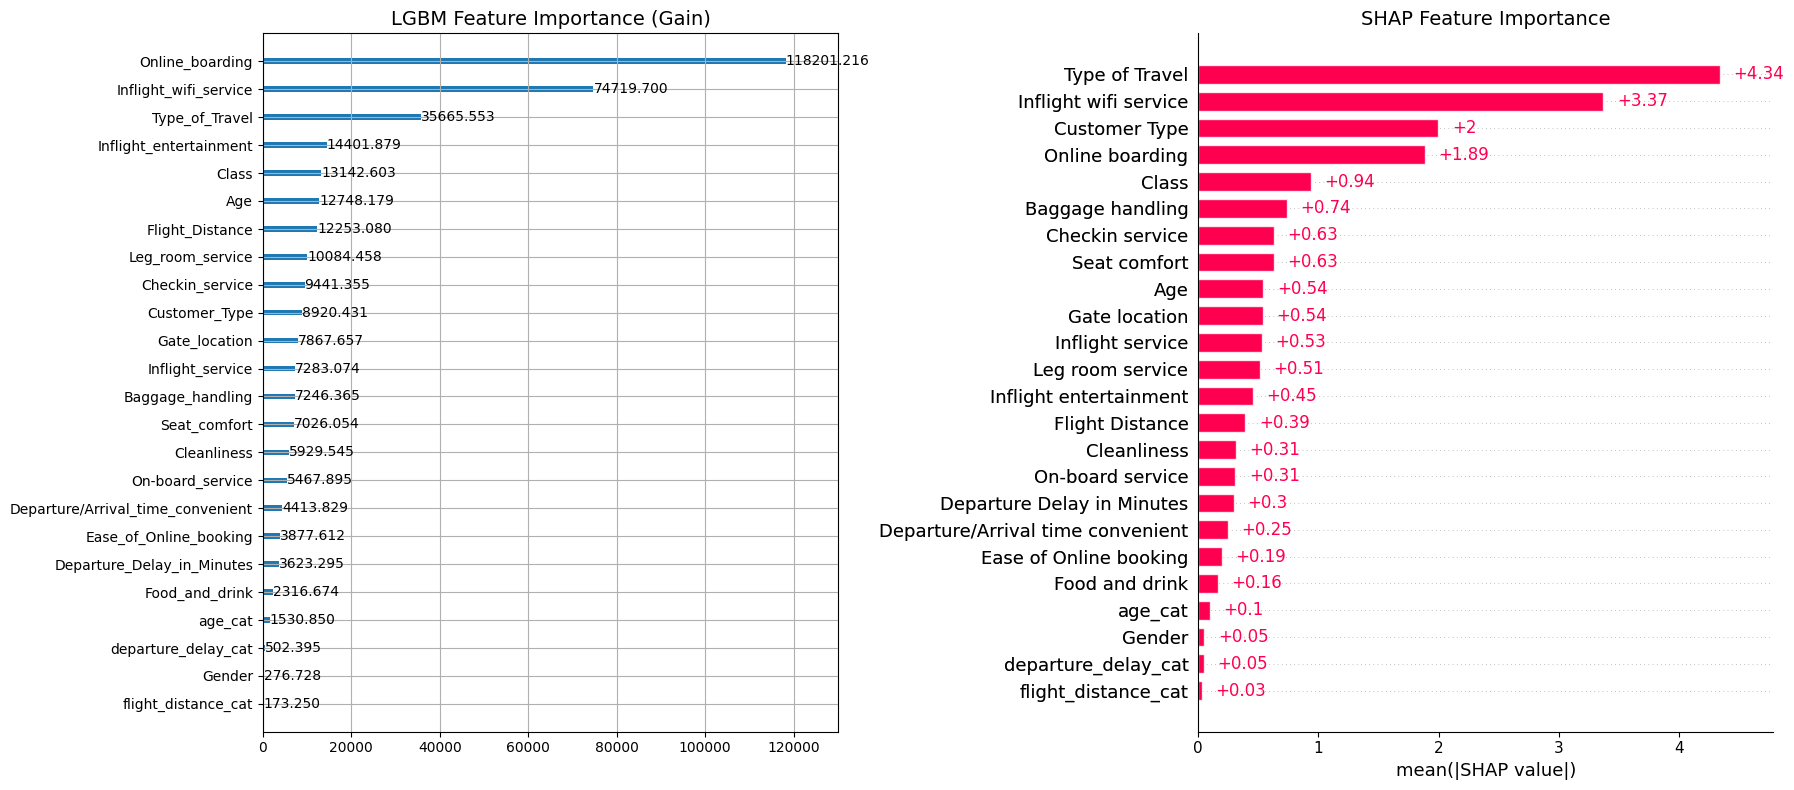

In [ ]:
def plot_feature_importances(model, shap_values, X_train, max_display=15):
    fig, axes = plt.subplots(nrows=1, ncols=2)
    plt.sca(axes[0])

    lgb.plot_importance(model, ax=axes[0], importance_type='gain')
    axes[0].set_title('LGBM Feature Importance (Gain)', fontsize=14)
    axes[0].set_xlabel('')
    axes[0].set_ylabel('')

    plt.sca(axes[1])
    shap.plots.bar(shap_values, max_display=X_train.shape[1], show=False)
    axes[1].set_title('SHAP Feature Importance', fontsize=14)
    fig.set_size_inches(18, 8)

    plt.tight_layout()
    plt.show()


plot_feature_importances(final_model, shap_values, X_train)

Both SHAP feature importance and model-based importance are almost identical. The difference is minuscule, so it can be disregarded. For that reason, features will be selected using a 0.01 threshold for SHAP values.

<a name="section-three"></a>
# **3. Final Model Evaluation**

This section focuses on the final comparison and evaluation of the models. After tuning the models and selecting the most important features, I will compare the performance of the full feature model against the SHAP-selected feature model.

* **Comparison of Full Feature Model vs. SHAP Selected Feature Model:**
  - I will evaluate and compare the key metrics (accuracy, precision, recall, F1 score, ROC AUC, etc.) of the full feature model and the model trained using the SHAP-selected features. This helps determine whether reducing the feature set leads to better or worse performance.

* **Predictions on the Test Set and Final Evaluation Metrics:**
  - The final selected model (whether full feature or SHAP-selected) will be evaluated on the test set. I will compute the final evaluation metrics, including accuracy, precision, recall, and F1 score, to measure how Ill the model generalizes to unseen data.

* **Save the Final Model:**
  - After evaluation, the best-performing model will be saved to disk using a serialization format (such as joblib or pickle). This ensures that the model can be loaded and used for future predictions without retraining.

<a name="section-three-one"></a>
## **Comparison of Full Feature Model vs. SHAP Selected Feature Model**

In [ ]:
shap_threshold = 0.1
feature_importance = np.abs(shap_values.values).mean(axis=0)
selected_features = X_train.columns[feature_importance > shap_threshold]
excluded_features = X_train.columns[feature_importance <= shap_threshold]
X_train_selected = X_train[selected_features]

print(f"Original number of features: {X_train.shape[1]}")
print(f"SHAP Threshold: {shap_threshold}")
print(f"Number of selected features: {len(selected_features)}")
print(f"Selected features: {list(selected_features)}")
print(f"Excluded features: {list(excluded_features)}")

Original number of features: 24
SHAP Threshold: 0.1
Number of selected features: 20
Selected features: ['Customer Type', 'Age', 'Type of Travel', 'Class', 'Flight Distance', 'Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking', 'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort', 'Inflight entertainment', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Inflight service', 'Cleanliness', 'Departure Delay in Minutes']
Excluded features: ['Gender', 'age_cat', 'flight_distance_cat', 'departure_delay_cat']


In [ ]:
def evaluate_final_model(model, X, y, cv=5):
    scoring = {'accuracy': 'accuracy',
               'precision': 'precision_weighted',
               'recall': 'recall_weighted',
               'f1': 'f1_weighted'
               }

    # Add ROC AUC for binary classification
    if len(np.unique(y)) == 2:
        scoring['roc_auc'] = 'roc_auc'

    cv_results = cross_validate(model, X, y, cv=cv, scoring=scoring)

    metrics_data = {'Mean': [np.mean(cv_results[f'test_{metric}']) for metric in scoring],
                    'Std': [np.std(cv_results[f'test_{metric}']) for metric in scoring]
                    }
    metric_names = [metric.replace("_", " ").capitalize() for metric in scoring]

    results_df = pd.DataFrame(metrics_data, index=metric_names)
    return results_df


def compare_models(model, X_full, X_selected, y, cv=5):
    start_full = time.time()
    full_results_df = evaluate_final_model(model, X_full, y, cv)
    full_time = time.time() - start_full

    start_selected = time.time()
    shap_results_df = evaluate_final_model(model, X_selected, y, cv)
    shap_time = time.time() - start_selected

    comparison_df = pd.concat(
        [full_results_df.rename(columns={'Mean': 'Full Features Mean', 'Std': 'Full Features Std'}),
         shap_results_df.rename(columns={'Mean': 'SHAP-selected Features Mean', 'Std': 'SHAP-selected Features Std'})],
        axis=1
    )

    print("\n" + "="*60)
    print(f"{'Training time for full features:':<41} {full_time:.4f} seconds")
    print(f"{'Training time for SHAP-selected features:':<40} {shap_time:.4f} seconds")
    print("="*60 + "\n")
    return comparison_df


comparison_df = compare_models(final_model, X_train, X_train_selected, y_train)
comparison_df


Training time for full features:          48.6165 seconds
Training time for SHAP-selected features: 45.5685 seconds



,Full Features Mean,Full Features Std,SHAP-selected Features Mean,SHAP-selected Features Std
Accuracy,0.962309,0.001434,0.962465,0.000939
Precision,0.962452,0.001435,0.962604,0.000941
Recall,0.962309,0.001434,0.962465,0.000939
F1,0.962242,0.001438,0.962400,0.000941
Roc auc,0.994862,0.000357,0.994832,0.000343


The results demonstrate that using SHAP-selected features leads to a slight improvement in both training efficiency and model performance:

* **Training time:** The SHAP-selected features reduce the training time from 48.62 seconds to 45.57 seconds, saving approximately 3.05 seconds. This indicates that the model is trained more efficiently with fewer features.
- **Performance metrics:** Although the differences are minimal, SHAP-selected features show slightly better performance across all metrics. For instance, accuracy improves from 0.96231 to 0.96247, precision from 0.96245 to 0.96260, and F1 score from 0.96224 to 0.96240. The recall mirrors accuracy, while the ROC AUC score remains nearly the same (a very slight decrease from 0.99486 to 0.99483).

Overall, SHAP-selected features provide comparable or marginally better results while reducing the computational cost, confirming the effectiveness of feature selection in maintaining model accuracy while improving efficiency.

<a name="section-three-two"></a>
## **Predictions on the Test Set and Final Evaluation Metrics**

In [ ]:
df_test_preprocessed.drop(columns=excluded_features, inplace=True)
X_test = df_test_preprocessed.drop(columns="satisfaction")
y_test = df_test_preprocessed.satisfaction

In [ ]:
df_train_preprocessed.drop(columns=excluded_features, inplace=True)
X = df_train_preprocessed.drop(columns="satisfaction")
y = df_train_preprocessed.satisfaction

In [ ]:
final_model_feat_selected = LGBMClassifier(**best_params_lgbm, verbose=-1).fit(X, y)

In [ ]:
y_pred = final_model_feat_selected.predict(X_test)

if hasattr(final_model_feat_selected, 'predict_proba'):
    y_pred_proba = final_model_feat_selected.predict_proba(X_test)[:, 1]
else:
    y_pred_proba = None

metrics = {
        "Accuracy" : accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall"   : recall_score(y_test, y_pred),
        "F1-Score" : f1_score(y_test, y_pred)
    }

if y_pred_proba is not None:
    metrics["ROC-AUC"] = roc_auc_score(y_test, y_pred_proba)

print("Model Performance on Test Set:")
for metric, score in metrics.items():
    print(f"{metric}: {score:.4f}")

Model Performance on Test Set:
Accuracy: 0.9498
Precision: 0.9685
Recall: 0.9154
F1-Score: 0.9412
ROC-AUC: 0.9916


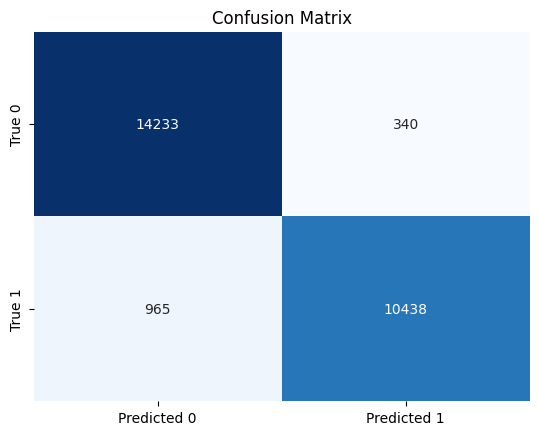

In [ ]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['True 0', 'True 1'])
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9365    0.9767    0.9562     14573
           1     0.9685    0.9154    0.9412     11403

    accuracy                         0.9498     25976
   macro avg     0.9525    0.9460    0.9487     25976
weighted avg     0.9505    0.9498    0.9496     25976



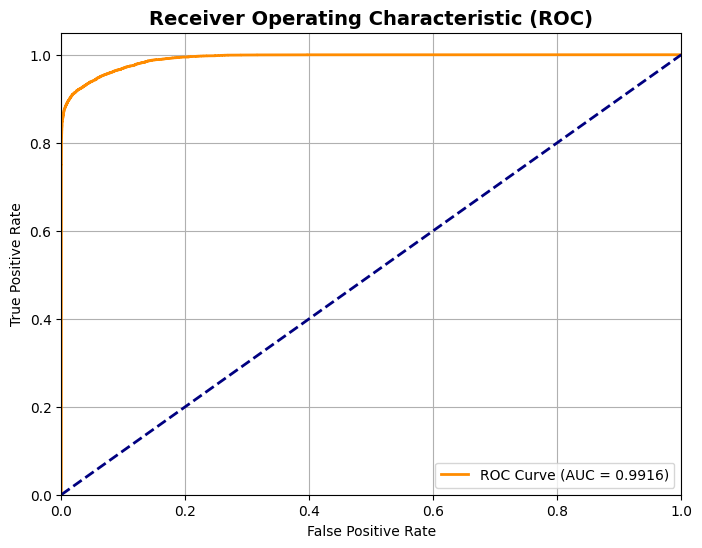

In [ ]:
def plot_model_roc_curve(model, X_test, y_test):
    if hasattr(model, 'predict_proba'):
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})', color='darkorange', lw=2)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC)', fontsize=14, fontweight='bold')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()
    else:
        print("Model does not support probability prediction.")


plot_model_roc_curve(final_model_feat_selected, X_test, y_test)

The model using SHAP-selected features performs exceptionally well on the test set, with strong predictive accuracy and a balanced trade-off between precision and recall. It excels at distinguishing between positive and negative classes, as reflected by the high ROC-AUC score, suggesting reliable classification across various thresholds. The confusion matrix shows minimal misclassifications, with the model handling the majority of both true positives and negatives effectively. This combination of high performance metrics points to a well-calibrated and robust model suitable for real-world application, particularly where false positives are less critical than identifying true positives.

<a name="section-three-three"></a>
## **Save the Final Model**

In [ ]:
# final_model = LGBMClassifier(**best_params_lgbm, verbose=-1).fit(X, y)
joblib.dump(final_model_feat_selected, 'final_model_feat_selected.pkl')
print("Model trained and saved as 'final_model_feat_selected.pkl'.")

Model trained and saved as 'final_model_feat_selected.pkl'.
